<a href="https://www.kaggle.com/code/nicholas33/stage1-aneurysmnet-intracranial-training-nb153?scriptVersionId=258346256" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# ====================================================
# RSNA INTRACRANIAL ANEURYSM - STAGE 1 TRAINING (v2)
# Uses Stage-0 prebuilt v2 cache (volumes, masks, pseudo_masks, brainmasks, manifest)
# Two-phase training with per-sample segmentation weights and rich progress logs:
#   Phase 1: real masks weighted (real_seg_weight), synthetic seg weight = 0.0
#   Phase 2: real same, synthetic seg weight = small (default 0.075)
# Saves: stage1_phase1_best.pth, stage1_phase2_best.pth, stage1_segmentation_best.pth
# ====================================================

import os
import math
import time
import random
import numpy as np
import pandas as pd
from typing import Optional, Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from tqdm import tqdm

In [3]:
# ====================================================
# Config
# ====================================================
class Config:
    # --- Paths ---
    PREBUILT_ROOT = "/kaggle/input/rsna2025-v2-intracranial-aneurysm-detection-nb153/stage1_AneurysmNet_prebuilt_v2"
    MANIFEST_PATH = os.path.join(PREBUILT_ROOT, "meta/manifest.csv")
    VOLUMES_DIR   = os.path.join(PREBUILT_ROOT, "volumes")
    MASKS_DIR     = os.path.join(PREBUILT_ROOT, "masks")          # real
    PSEUDO_DIR    = os.path.join(PREBUILT_ROOT, "pseudo_masks")   # synthetic
    BRAINMASKS_DIR= os.path.join(PREBUILT_ROOT, "brainmasks")

    # --- Data ---
    TARGET_SIZE = (48, 112, 112)  # (D,H,W)
    USE_BRAINMASKS = True
    BRAINMASK_KEY = 'm'
    BRAINMASK_MIN_FRAC = 0.02  # if below, skip masking

    # --- Training ---
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    MIXED_PRECISION = True
    STAGE1_BATCH_SIZE = 12  # bump to 12/16 if GPU mem allows
    NUM_WORKERS = 4        # bump to 4/8 to reduce CPU bottlenecks
    PREFETCH_FACTOR = 4
    PERSISTENT_WORKERS = True
    STAGE1_LR = 2e-4
    WEIGHT_DECAY = 1e-4
    EPOCHS_PHASE1 = 15
    EPOCHS_PHASE2 = 10
    EARLY_STOP_PATIENCE = 5
    GRAD_ACCUM_STEPS = 8
    # Validation throughput
    VAL_BATCH_MULT = 1  # keep validation batch moderate to avoid I/O stalls
    VAL_NUM_WORKERS = 4  # allow more workers for validation to feed GPUs

    # --- Segmentation weights ---
    REAL_SEG_DEFAULT_W = 0.7      # used if manifest lacks real_seg_weight
    PHASE1_SYNTH_SEG_W = 0.0
    PHASE2_SYNTH_SEG_W = 0.075
    FOCAL_LOSS_WEIGHT = 0.2

    # --- Splits ---
    FOLDS = 1   # set >1 later if you want CV here
    SEED = 42

# ====================================================
# Utils
# ====================================================

def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True  # speeds up fixed-size convs


def load_manifest_df() -> pd.DataFrame:
    df = pd.read_csv(Config.MANIFEST_PATH)
    # Required columns: series_id, label, vol_relpath
    for col in ["series_id", "label", "vol_relpath"]:
        if col not in df.columns:
            raise RuntimeError(f"Manifest missing required column: {col}")
    return df


def gpu_mem_str():
    if not torch.cuda.is_available():
        return "cpu"
    try:
        a = torch.cuda.memory_allocated() / (1024**3)
        r = torch.cuda.memory_reserved() / (1024**3)
        return f"{a:.2f}G/{r:.2f}G"
    except Exception:
        return "gpu"

In [4]:
# ====================================================
# Dataset
# ====================================================
class PrebuiltDataset(Dataset):
    def __init__(self, df: pd.DataFrame, phase_synth_w: float):
        self.df = df.reset_index(drop=True)
        self.phase_synth_w = float(phase_synth_w)

    def __len__(self):
        return len(self.df)

    def _load_volume(self, sid: str) -> np.ndarray:
        path = os.path.join(Config.VOLUMES_DIR, f"{sid}.npy")
        v = np.load(path).astype(np.float32)  # (D,H,W), 0..1
        v = np.nan_to_num(v, nan=0.0, posinf=1.0, neginf=0.0)
        return v

    def _load_brainmask(self, sid: str, frac: Optional[float], shp: Tuple[int,int,int]):
        if not Config.USE_BRAINMASKS:
            return None
        if frac is not None and float(frac) < Config.BRAINMASK_MIN_FRAC:
            return None
        p = os.path.join(Config.BRAINMASKS_DIR, f"{sid}_brainmask.npz")
        if not os.path.exists(p):
            return None
        try:
            bm = np.load(p)[Config.BRAINMASK_KEY].astype(np.float32)
            bm = np.nan_to_num(bm, nan=0.0, posinf=1.0, neginf=0.0)
            if bm.shape != shp or bm.sum() <= 0:
                return None
            return bm
        except Exception:
            return None

    def _load_mask(self, sid: str, mask_rel: str, is_synth: int, label: int) -> Tuple[np.ndarray, bool]:
        # Returns (mask[D,H,W] float32 in {0,1}, is_synthetic: bool)
        if isinstance(mask_rel, str) and len(mask_rel) > 0:
            if mask_rel.startswith('masks/'):
                p = os.path.join(Config.PREBUILT_ROOT, mask_rel)
                if os.path.exists(p):
                    m = np.load(p).astype(np.float32)
                    m = np.nan_to_num(m, nan=0.0, posinf=1.0, neginf=0.0)
                    return (m > 0).astype(np.float32), False
            elif mask_rel.startswith('pseudo_masks/'):
                p = os.path.join(Config.PREBUILT_ROOT, mask_rel)
                if os.path.exists(p):
                    m = np.load(p).astype(np.float32)
                    m = np.nan_to_num(m, nan=0.0, posinf=1.0, neginf=0.0)
                    return (m > 0).astype(np.float32), True
        # Fallbacks
        D,H,W = Config.TARGET_SIZE
        if int(label) == 1:
            return np.zeros((D,H,W), dtype=np.float32), True
        else:
            return np.zeros((D,H,W), dtype=np.float32), False

    def __getitem__(self, idx):
        r = self.df.iloc[idx]
        sid = str(r['series_id'])
        label = int(r['label'])
        mask_rel = r.get('mask_relpath', '') if isinstance(r.get('mask_relpath', ''), str) else ''
        is_synth_col = int(r.get('is_synthetic', 0))
        real_seg_weight = r.get('real_seg_weight', np.nan)
        brain_frac = r.get('brain_voxel_fraction', np.nan)

        vol = self._load_volume(sid)  # (D,H,W)
        bm = self._load_brainmask(sid, brain_frac if pd.notna(brain_frac) else None, vol.shape)
        if bm is not None:
            vol = vol * bm  # gate

        mask, is_synth = self._load_mask(sid, mask_rel, is_synth_col, label)

        # per-sample seg weight
        if is_synth:
            seg_w = self.phase_synth_w
        else:
            if pd.notna(real_seg_weight):
                try:
                    rsw = float(real_seg_weight)
                except Exception:
                    rsw = Config.REAL_SEG_DEFAULT_W
            else:
                rsw = Config.REAL_SEG_DEFAULT_W
            seg_w = float(np.clip(rsw, 0.2, 1.0))

        # to tensors
        vol_t = torch.from_numpy(vol).unsqueeze(0)         # [1,D,H,W]
        mask_t = torch.from_numpy((mask > 0).astype(np.float32)).unsqueeze(0)
        label_t = torch.tensor([float(label)], dtype=torch.float32)
        segw_t  = torch.tensor([float(seg_w)], dtype=torch.float32)

        return {
            'series_id': sid,
            'volume': vol_t,
            'mask': mask_t,
            'label': label_t,
            'seg_weight': segw_t,
            'is_synthetic_mask': torch.tensor([1.0 if is_synth else 0.0], dtype=torch.float32),
        }

# ====================================================
# Simple 3D UNet + classifier head
# ====================================================
class ConvBlock3D(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv3d(in_ch, out_ch, 3, padding=1), nn.GroupNorm(num_groups=8, num_channels=out_ch), nn.ReLU(inplace=True),
            nn.Conv3d(out_ch, out_ch, 3, padding=1), nn.GroupNorm(num_groups=8, num_channels=out_ch), nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.net(x)

class UNet3D(nn.Module):
    def __init__(self, in_ch=1, base=24):
        super().__init__()
        b = base
        self.enc1 = ConvBlock3D(in_ch, b)
        self.pool1 = nn.MaxPool3d(2)
        self.enc2 = ConvBlock3D(b, b*2)
        self.pool2 = nn.MaxPool3d(2)
        self.enc3 = ConvBlock3D(b*2, b*4)
        self.pool3 = nn.MaxPool3d((2,2,2))
        self.bott = ConvBlock3D(b*4, b*8)
        self.up3 = nn.ConvTranspose3d(b*8, b*4, 2, stride=2)
        self.dec3 = ConvBlock3D(b*8, b*4)
        self.up2 = nn.ConvTranspose3d(b*4, b*2, 2, stride=2)
        self.dec2 = ConvBlock3D(b*4, b*2)
        self.up1 = nn.ConvTranspose3d(b*2, b, 2, stride=2)
        self.dec1 = ConvBlock3D(b*2, b)
        self.seg_head = nn.Conv3d(b, 1, 1)
        # classification head from bottleneck features
        self.cls_pool = nn.AdaptiveAvgPool3d(1)
        self.cls_head = nn.Linear(b*8, 1)

    def forward(self, x):  # x: [B,1,D,H,W]
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        e3 = self.enc3(self.pool2(e2))
        b  = self.bott(self.pool3(e3))
        # decoder
        d3 = self.up3(b)
        d3 = torch.cat([d3, e3], dim=1)
        d3 = self.dec3(d3)
        d2 = self.up2(d3)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)
        d1 = self.up1(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)
        seg = self.seg_head(d1)  # [B,1,D,H,W]
        # classifier from bottleneck
        cls = self.cls_head(self.cls_pool(b).flatten(1))  # [B,1]
        return seg, cls

# ====================================================
# Losses
# ====================================================
class DiceLoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.eps = eps
    def forward(self, logits, targets, reduction='mean'):
        probs = torch.sigmoid(logits)
        num = 2 * (probs * targets).sum(dim=(2,3,4)) + self.eps
        den = (probs.pow(2) + targets.pow(2)).sum(dim=(2,3,4)) + self.eps
        dice = 1 - (num / den)  # per-sample
        if reduction == 'none':
            return dice
        return dice.mean()

class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, eps=1e-6):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.eps = eps
    def forward(self, logits, targets, reduction='mean'):
        probs = torch.sigmoid(logits).clamp(self.eps, 1-self.eps)
        ce = -(targets*torch.log(probs) + (1-targets)*torch.log(1-probs))
        pt = torch.where(targets==1, probs, 1-probs)
        loss = self.alpha * (1-pt).pow(self.gamma) * ce
        loss = loss.mean(dim=(2,3,4))  # per-sample
        if reduction == 'none':
            return loss
        return loss.mean()

class EnhancedCombinedLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.dice_loss = DiceLoss()
        self.focal_loss = FocalLoss(alpha=0.25, gamma=2.0)
        self.bce_vox = nn.BCEWithLogitsLoss(reduction='none')
        self.bce_cls = nn.BCEWithLogitsLoss()
    def forward(self, seg_logits, cls_logits, seg_targets, cls_targets, seg_weights: torch.Tensor):
        # clamp seg logits to avoid AMP overflow
        seg_logits = torch.nan_to_num(seg_logits, nan=0.0, posinf=20.0, neginf=-20.0)
        B = seg_logits.shape[0]
        dice_ps = self.dice_loss(seg_logits, seg_targets, reduction='none')
        focal_ps= self.focal_loss(seg_logits, seg_targets, reduction='none')
        bce_elem= self.bce_vox(seg_logits, seg_targets)
        bce_ps  = bce_elem.view(B, -1).mean(dim=1)
        dice_ps = torch.nan_to_num(dice_ps, nan=0.0)
        focal_ps= torch.nan_to_num(focal_ps, nan=0.0)
        bce_ps  = torch.nan_to_num(bce_ps,  nan=0.0)
        seg_ps  = 0.5*dice_ps + 0.3*bce_ps + Config.FOCAL_LOSS_WEIGHT*focal_ps
        seg_ps  = torch.nan_to_num(seg_ps, nan=0.0)
        seg_w   = seg_weights.view(-1)
        if (seg_w == 0).all():
            seg_loss = seg_ps.new_tensor(0.0)
        else:
            seg_loss = (seg_ps * seg_w).mean()
        # classification loss
        cls_logits = torch.nan_to_num(cls_logits, nan=0.0, posinf=20.0, neginf=-20.0)
        cls_loss= self.bce_cls(cls_logits.view(-1), cls_targets.view(-1))
        total   = seg_loss + cls_loss
        return total, seg_loss.detach(), cls_loss.detach()

# ====================================================
# Train / Validate with progress bars
# ====================================================

def train_epoch(model, loader, optimizer, criterion, scaler, epoch=None, phase_name="P1"):
    model.train()
    t_loss = t_seg = t_cls = 0.0
    n = 0
    pbar = tqdm(loader, desc=f"Train {phase_name}{'' if epoch is None else f' [ep {epoch}]'}", leave=False, mininterval=0.1)
    optimizer.zero_grad(set_to_none=True)
    for iter_idx, batch in enumerate(pbar):
        vol   = batch['volume'].to(Config.DEVICE, non_blocking=True)
        try:
            vol = vol.to(memory_format=torch.channels_last_3d)
        except Exception:
            pass
        mask  = batch['mask'].to(Config.DEVICE, non_blocking=True)
        label = batch['label'].to(Config.DEVICE, non_blocking=True)
        segw  = batch['seg_weight'].to(Config.DEVICE, non_blocking=True)
        with torch.amp.autocast('cuda', enabled=Config.MIXED_PRECISION):
            seg_logits, cls_logits = model(vol)
            loss, seg_loss, cls_loss = criterion(seg_logits, cls_logits, mask, label, segw)
        try:
            scaler.scale(loss / Config.GRAD_ACCUM_STEPS).backward()
            if ((iter_idx + 1) % Config.GRAD_ACCUM_STEPS) == 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad(set_to_none=True)
        except Exception:
            optimizer.zero_grad(set_to_none=True)
            continue
        bs = vol.size(0)
        t_loss += loss.item()*bs; t_seg += seg_loss.item()*bs; t_cls += cls_loss.item()*bs; n += bs
        pbar.set_postfix(loss=f"{t_loss/max(n,1):.4f}", seg=f"{t_seg/max(n,1):.4f}", cls=f"{t_cls/max(n,1):.4f}", lr=f"{optimizer.param_groups[0]['lr']:.2e}")
    # finalize leftover accumulation
    if (len(loader) % Config.GRAD_ACCUM_STEPS) != 0:
        try:
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
        except Exception:
            pass
        finally:
            optimizer.zero_grad(set_to_none=True)
    return t_loss/n, t_seg/n, t_cls/n

@torch.no_grad()
def validate_epoch(model, loader, criterion, epoch=None, phase_name="P1"):
    model.eval()
    t_loss = t_seg = t_cls = 0.0
    n = 0
    all_probs = []
    all_labels= []
    pbar = tqdm(loader, desc=f"Valid {phase_name}{'' if epoch is None else f' [ep {epoch}]'}", leave=False, mininterval=0.1)
    for batch in pbar:
        vol   = batch['volume'].to(Config.DEVICE, non_blocking=True)
        try:
            vol = vol.to(memory_format=torch.channels_last_3d)
        except Exception:
            pass
        mask  = batch['mask'].to(Config.DEVICE, non_blocking=True)
        label = batch['label'].to(Config.DEVICE, non_blocking=True)
        segw  = batch['seg_weight'].to(Config.DEVICE, non_blocking=True)
        with torch.amp.autocast('cuda', enabled=Config.MIXED_PRECISION):
            seg_logits, cls_logits = model(vol)
            loss, seg_loss, cls_loss = criterion(seg_logits, cls_logits, mask, label, segw)
        bs = vol.size(0)
        t_loss += loss.item()*bs; t_seg += seg_loss.item()*bs; t_cls += cls_loss.item()*bs; n += bs
        pbar.set_postfix(loss=f"{t_loss/max(n,1):.4f}", seg=f"{t_seg/max(n,1):.4f}", cls=f"{t_cls/max(n,1):.4f}")
        all_probs.append(torch.sigmoid(cls_logits).detach().cpu().view(-1).numpy())
        all_labels.append(label.detach().cpu().view(-1).numpy())
    all_probs = np.concatenate(all_probs) if len(all_probs)>0 else np.array([])
    all_labels = np.concatenate(all_labels) if len(all_labels)>0 else np.array([])
    auc = np.nan
    try:
        if len(all_probs)>0 and len(np.unique(all_labels)) > 1:
            auc = float(roc_auc_score(all_labels, all_probs))
    except Exception:
        pass
    return t_loss/n, t_seg/n, t_cls/n, auc

# ====================================================
# Main
# ====================================================

def run_training():
    set_seed(Config.SEED)
    # TF32 for better throughput
    try:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
        torch.set_float32_matmul_precision('high')
    except Exception:
        pass
    df = load_manifest_df()

    # Build a single stratified split (can expand to CV later)
    y = df['label'].astype(int).values
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=Config.SEED)
    train_idx, val_idx = next(skf.split(np.zeros_like(y), y))
    train_df = df.iloc[train_idx].reset_index(drop=True)
    val_df   = df.iloc[val_idx].reset_index(drop=True)

    # Phase 1 datasets/loads
    ds_train_p1 = PrebuiltDataset(train_df, phase_synth_w=Config.PHASE1_SYNTH_SEG_W)
    ds_val_p1   = PrebuiltDataset(val_df,   phase_synth_w=Config.PHASE1_SYNTH_SEG_W)
    dl_train = DataLoader(ds_train_p1, batch_size=Config.STAGE1_BATCH_SIZE, shuffle=True,
                          num_workers=Config.NUM_WORKERS, pin_memory=True,
                          prefetch_factor=Config.PREFETCH_FACTOR,
                          persistent_workers=Config.PERSISTENT_WORKERS)
    dl_val   = DataLoader(ds_val_p1,   batch_size=Config.STAGE1_BATCH_SIZE * Config.VAL_BATCH_MULT, shuffle=False,
                          num_workers=Config.VAL_NUM_WORKERS, pin_memory=True,
                          prefetch_factor=Config.PREFETCH_FACTOR,
                          persistent_workers=Config.PERSISTENT_WORKERS)

    model = UNet3D(in_ch=1, base=24).to(Config.DEVICE)
    try:
        model = model.to(memory_format=torch.channels_last_3d)
    except Exception:
        pass
    # Multi-GPU (if available): enable DP for train and val
    dp_enabled = False
    if torch.cuda.is_available() and torch.cuda.device_count() > 1:
        dp_enabled = True
        print(f"Using {torch.cuda.device_count()} GPUs via DataParallel")
        model = nn.DataParallel(model)

    optimizer = torch.optim.AdamW(model.parameters(), lr=Config.STAGE1_LR, weight_decay=Config.WEIGHT_DECAY)
    criterion = EnhancedCombinedLoss().to(Config.DEVICE)
    scaler = torch.amp.GradScaler('cuda', enabled=Config.MIXED_PRECISION)

    best_loss = float('inf'); best_state = None; patience = 0
    for epoch in range(1, Config.EPOCHS_PHASE1+1):
        print(f"\n[Phase 1] Epoch {epoch}/{Config.EPOCHS_PHASE1}")
        tr_loss, tr_seg, tr_cls = train_epoch(model, dl_train, optimizer, criterion, scaler, epoch=epoch, phase_name='P1')
        # Always validate every epoch
        va_loss, va_seg, va_cls, va_auc = validate_epoch(model, dl_val, criterion, epoch=epoch, phase_name='P1')
        print(f"Train Loss: {tr_loss:.4f} | Seg: {tr_seg:.4f} | Cls: {tr_cls:.4f} | GPU {gpu_mem_str()}")
        print(f" Val  Loss: {va_loss:.4f} | Seg: {va_seg:.4f} | Cls: {va_cls:.4f} | AUC: {va_auc if not np.isnan(va_auc) else 'NA'} | GPU {gpu_mem_str()}")
        if va_loss < best_loss - 1e-5:
            best_loss = va_loss; best_state = {k:v.detach().cpu() for k,v in (model.module.state_dict() if isinstance(model, nn.DataParallel) else model.state_dict()).items()}; patience = 0
            torch.save(best_state, 'stage1_phase1_best.pth')
            print("💾 Saved Phase 1 best checkpoint")
        else:
            patience += 1
            if patience >= Config.EARLY_STOP_PATIENCE:
                print("Early stopping Phase 1")
                break

    if best_state is not None:
        if isinstance(model, nn.DataParallel):
            model.module.load_state_dict(best_state)
        else:
            model.load_state_dict(best_state)

    # Phase 2: small synthetic weight
    print("\n====== PHASE 2: enabling small synthetic seg supervision ======")
    ds_train_p2 = PrebuiltDataset(train_df, phase_synth_w=Config.PHASE2_SYNTH_SEG_W)
    ds_val_p2   = PrebuiltDataset(val_df,   phase_synth_w=Config.PHASE2_SYNTH_SEG_W)
    dl_train2 = DataLoader(ds_train_p2, batch_size=Config.STAGE1_BATCH_SIZE, shuffle=True,
                           num_workers=Config.NUM_WORKERS, pin_memory=True,
                           prefetch_factor=Config.PREFETCH_FACTOR,
                           persistent_workers=Config.PERSISTENT_WORKERS)
    dl_val2   = DataLoader(ds_val_p2,   batch_size=Config.STAGE1_BATCH_SIZE * Config.VAL_BATCH_MULT, shuffle=False,
                           num_workers=Config.VAL_NUM_WORKERS, pin_memory=True,
                           prefetch_factor=Config.PREFETCH_FACTOR,
                           persistent_workers=Config.PERSISTENT_WORKERS)

    # optional: lower LR a bit for fine-tune
    for g in optimizer.param_groups:
        g['lr'] = Config.STAGE1_LR * 0.5

    best2 = float('inf'); best2_state = None; patience = 0
    for epoch in range(1, Config.EPOCHS_PHASE2+1):
        print(f"\n[Phase 2] Epoch {epoch}/{Config.EPOCHS_PHASE2}")
        tr_loss, tr_seg, tr_cls = train_epoch(model, dl_train2, optimizer, criterion, scaler, epoch=epoch, phase_name='P2')
        va_loss, va_seg, va_cls, va_auc = validate_epoch(model, dl_val2, criterion, epoch=epoch, phase_name='P2')
        print(f"Train Loss: {tr_loss:.4f} | Seg: {tr_seg:.4f} | Cls: {tr_cls:.4f} | GPU {gpu_mem_str()}")
        print(f" Val  Loss: {va_loss:.4f} | Seg: {va_seg:.4f} | Cls: {va_cls:.4f} | AUC: {va_auc if not np.isnan(va_auc) else 'NA'} | GPU {gpu_mem_str()}")
        if va_loss < best2 - 1e-5:
            best2 = va_loss; best2_state = {k:v.detach().cpu() for k,v in (model.module.state_dict() if isinstance(model, nn.DataParallel) else model.state_dict()).items()}; patience = 0
            torch.save(best2_state, 'stage1_phase2_best.pth')
            print("💾 Saved Phase 2 best checkpoint")
        else:
            patience += 1
            if patience >= Config.EARLY_STOP_PATIENCE:
                print("Early stopping Phase 2")
                break

    final_state = best2_state or best_state or (model.module.state_dict() if isinstance(model, nn.DataParallel) else model.state_dict())
    torch.save(final_state, 'stage1_segmentation_best.pth')
    print("\n✅ Stage 1 complete. Saved: stage1_segmentation_best.pth")


if __name__ == '__main__':
    run_training()


Using 2 GPUs via DataParallel

[Phase 1] Epoch 1/15


Train Loss: 0.9511 | Seg: 0.2503 | Cls: 0.7008 | GPU 0.05G/0.25G
 Val  Loss: 0.9216 | Seg: 0.2438 | Cls: 0.6778 | AUC: 0.5754446248536798 | GPU 0.05G/0.25G
💾 Saved Phase 1 best checkpoint

[Phase 1] Epoch 2/15


Train Loss: 0.9239 | Seg: 0.2436 | Cls: 0.6804 | GPU 0.05G/0.25G
 Val  Loss: 0.9490 | Seg: 0.2416 | Cls: 0.7074 | AUC: 0.6105453093898512 | GPU 0.05G/0.25G

[Phase 1] Epoch 3/15


Train Loss: 0.9134 | Seg: 0.2418 | Cls: 0.6716 | GPU 0.05G/0.25G
 Val  Loss: 0.9012 | Seg: 0.2400 | Cls: 0.6612 | AUC: 0.6437121387844493 | GPU 0.05G/0.25G
💾 Saved Phase 1 best checkpoint

[Phase 1] Epoch 4/15


Train Loss: 0.9221 | Seg: 0.2404 | Cls: 0.6818 | GPU 0.05G/0.25G
 Val  Loss: 0.9205 | Seg: 0.2386 | Cls: 0.6819 | AUC: 0.566417270378302 | GPU 0.05G/0.25G

[Phase 1] Epoch 5/15


Train Loss: 0.9217 | Seg: 0.2384 | Cls: 0.6833 | GPU 0.05G/0.25G
 Val  Loss: 0.9067 | Seg: 0.2360 | Cls: 0.6707 | AUC: 0.6062055982004628 | GPU 0.05G/0.25G

[Phase 1] Epoch 6/15


Train Loss: 0.9085 | Seg: 0.2361 | Cls: 0.6725 | GPU 0.05G/0.25G
 Val  Loss: 0.8930 | Seg: 0.2345 | Cls: 0.6586 | AUC: 0.6537347408849882 | GPU 0.05G/0.25G
💾 Saved Phase 1 best checkpoint

[Phase 1] Epoch 7/15


Train Loss: 0.9006 | Seg: 0.2351 | Cls: 0.6655 | GPU 0.05G/0.25G
 Val  Loss: 0.8923 | Seg: 0.2337 | Cls: 0.6586 | AUC: 0.6579342003765218 | GPU 0.05G/0.25G
💾 Saved Phase 1 best checkpoint

[Phase 1] Epoch 8/15


Train Loss: 0.8986 | Seg: 0.2343 | Cls: 0.6643 | GPU 0.05G/0.25G
 Val  Loss: 0.8818 | Seg: 0.2328 | Cls: 0.6490 | AUC: 0.6577885543825959 | GPU 0.05G/0.25G
💾 Saved Phase 1 best checkpoint

[Phase 1] Epoch 9/15


Train Loss: 0.8943 | Seg: 0.2334 | Cls: 0.6609 | GPU 0.05G/0.25G
 Val  Loss: 0.8802 | Seg: 0.2320 | Cls: 0.6482 | AUC: 0.660874091735399 | GPU 0.05G/0.25G
💾 Saved Phase 1 best checkpoint

[Phase 1] Epoch 10/15


Train Loss: 0.8894 | Seg: 0.2327 | Cls: 0.6567 | GPU 0.05G/0.25G
 Val  Loss: 0.8820 | Seg: 0.2312 | Cls: 0.6509 | AUC: 0.6627728839525087 | GPU 0.05G/0.25G

[Phase 1] Epoch 11/15


Train Loss: 0.8962 | Seg: 0.2318 | Cls: 0.6644 | GPU 0.05G/0.25G
 Val  Loss: 0.8793 | Seg: 0.2303 | Cls: 0.6490 | AUC: 0.6511454787707478 | GPU 0.05G/0.25G
💾 Saved Phase 1 best checkpoint

[Phase 1] Epoch 12/15


Train Loss: 0.8880 | Seg: 0.2311 | Cls: 0.6569 | GPU 0.05G/0.25G
 Val  Loss: 0.8769 | Seg: 0.2296 | Cls: 0.6473 | AUC: 0.6645826702844413 | GPU 0.05G/0.25G
💾 Saved Phase 1 best checkpoint

[Phase 1] Epoch 13/15


Train Loss: 0.8847 | Seg: 0.2304 | Cls: 0.6543 | GPU 0.05G/0.25G
 Val  Loss: 0.8737 | Seg: 0.2289 | Cls: 0.6448 | AUC: 0.6608174516266501 | GPU 0.05G/0.25G
💾 Saved Phase 1 best checkpoint

[Phase 1] Epoch 14/15


Train Loss: 0.8872 | Seg: 0.2298 | Cls: 0.6575 | GPU 0.05G/0.25G
 Val  Loss: 0.8802 | Seg: 0.2282 | Cls: 0.6520 | AUC: 0.6632098219342867 | GPU 0.05G/0.25G

[Phase 1] Epoch 15/15


Train Loss: 0.8849 | Seg: 0.2290 | Cls: 0.6560 | GPU 0.05G/0.25G
 Val  Loss: 0.8715 | Seg: 0.2274 | Cls: 0.6440 | AUC: 0.6682427001688415 | GPU 0.05G/0.25G
💾 Saved Phase 1 best checkpoint

====== PHASE 2: enabling small synthetic seg supervision ======

[Phase 2] Epoch 1/10


Train Loss: 0.8944 | Seg: 0.2443 | Cls: 0.6500 | GPU 0.05G/0.25G
 Val  Loss: 0.8830 | Seg: 0.2430 | Cls: 0.6400 | AUC: 0.6723693366634121 | GPU 0.05G/0.25G
💾 Saved Phase 2 best checkpoint

[Phase 2] Epoch 2/10


Train Loss: 0.8951 | Seg: 0.2440 | Cls: 0.6512 | GPU 0.05G/0.25G
 Val  Loss: 0.8856 | Seg: 0.2426 | Cls: 0.6430 | AUC: 0.6707995965066539 | GPU 0.05G/0.25G

[Phase 2] Epoch 3/10


Train Loss: 0.8884 | Seg: 0.2436 | Cls: 0.6449 | GPU 0.05G/0.25G
 Val  Loss: 0.8802 | Seg: 0.2422 | Cls: 0.6380 | AUC: 0.6715817694369973 | GPU 0.05G/0.25G
💾 Saved Phase 2 best checkpoint

[Phase 2] Epoch 4/10


Train Loss: 0.8878 | Seg: 0.2432 | Cls: 0.6446 | GPU 0.05G/0.25G
 Val  Loss: 0.8845 | Seg: 0.2419 | Cls: 0.6427 | AUC: 0.6696802800718521 | GPU 0.05G/0.25G

[Phase 2] Epoch 5/10


Train Loss: 0.8882 | Seg: 0.2429 | Cls: 0.6453 | GPU 0.05G/0.25G
 Val  Loss: 0.8786 | Seg: 0.2416 | Cls: 0.6371 | AUC: 0.6731649953339338 | GPU 0.05G/0.25G
💾 Saved Phase 2 best checkpoint

[Phase 2] Epoch 6/10


Train Loss: 0.8864 | Seg: 0.2426 | Cls: 0.6438 | GPU 0.05G/0.25G
 Val  Loss: 0.8807 | Seg: 0.2413 | Cls: 0.6395 | AUC: 0.6699661777636328 | GPU 0.05G/0.25G

[Phase 2] Epoch 7/10


Train Loss: 0.8853 | Seg: 0.2423 | Cls: 0.6430 | GPU 0.05G/0.25G
 Val  Loss: 0.8838 | Seg: 0.2410 | Cls: 0.6428 | AUC: 0.6762262583544161 | GPU 0.05G/0.25G

[Phase 2] Epoch 8/10


Train Loss: 0.8887 | Seg: 0.2420 | Cls: 0.6467 | GPU 0.05G/0.25G
 Val  Loss: 0.8794 | Seg: 0.2407 | Cls: 0.6387 | AUC: 0.6716842610623526 | GPU 0.05G/0.25G

[Phase 2] Epoch 9/10


Train Loss: 0.8872 | Seg: 0.2418 | Cls: 0.6453 | GPU 0.05G/0.25G
 Val  Loss: 0.8761 | Seg: 0.2405 | Cls: 0.6357 | AUC: 0.6754656626083579 | GPU 0.05G/0.25G
💾 Saved Phase 2 best checkpoint

[Phase 2] Epoch 10/10


Train Loss: 0.8868 | Seg: 0.2415 | Cls: 0.6453 | GPU 0.05G/0.25G
 Val  Loss: 0.8748 | Seg: 0.2402 | Cls: 0.6347 | AUC: 0.6755897314179986 | GPU 0.05G/0.25G
💾 Saved Phase 2 best checkpoint

✅ Stage 1 complete. Saved: stage1_segmentation_best.pth


In [6]:
# --- Config for quick eval ---
CKPT = "stage1_phase1_best.pth"  # later compare with "stage1_phase2_best.pth"
DEVICE = Config.DEVICE
BATCH = Config.STAGE1_BATCH_SIZE
WORKERS = max(2, Config.NUM_WORKERS)

# Val split identical to training: 5-fold StratifiedKFold, same SEED
df = load_manifest_df()
y = df["label"].astype(int).values
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=Config.SEED)
train_idx, val_idx = next(skf.split(np.zeros_like(y), y))
val_df = df.iloc[val_idx].reset_index(drop=True)

# Dataloader (no synthetic seg weight needed for eval)
val_ds = PrebuiltDataset(val_df, phase_synth_w=0.0)
val_dl = DataLoader(val_ds, batch_size=BATCH, shuffle=False,
                    num_workers=WORKERS, pin_memory=True,
                    prefetch_factor=getattr(Config, "PREFETCH_FACTOR", 2),
                    persistent_workers=getattr(Config, "PERSISTENT_WORKERS", True))

# Load model
model = UNet3D(in_ch=1, base=24)
state = torch.load(CKPT, map_location="cpu")
model.load_state_dict(state)
model.to(DEVICE)
model.eval()
print(f"Loaded {CKPT}")

Loaded stage1_phase1_best.pth


In [7]:
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_fscore_support

probs = []
labels = []

with torch.no_grad():
    for batch in val_dl:
        vol = batch["volume"].to(DEVICE, non_blocking=True)
        _, cls_logits = model(vol)
        p = torch.sigmoid(cls_logits).squeeze(1).detach().cpu().numpy()
        probs.append(p)
        labels.append(batch["label"].view(-1).numpy())

probs = np.concatenate(probs)
labels = np.concatenate(labels).astype(int)

auc = roc_auc_score(labels, probs) if len(np.unique(labels))>1 else np.nan
fpr, tpr, thr = roc_curve(labels, probs)
youden = tpr - fpr
best_idx = int(np.argmax(youden))
best_thr = float(thr[best_idx]) if thr.size else 0.5

pred = (probs >= best_thr).astype(int)
prec, rec, f1, _ = precision_recall_fscore_support(labels, pred, average="binary", zero_division=0)

print(f"AUC: {auc:.4f}")
print(f"Best threshold (Youden): {best_thr:.3f} | Precision {prec:.3f} | Recall {rec:.3f} | F1 {f1:.3f}")
print("Confusion @ best thr:",
      f"TN={(pred==0)&(labels==0).sum()}",
      f"FP={(pred==1)&(labels==0).sum()}",
      f"FN={(pred==0)&(labels==1).sum()}",
      f"TP={(pred==1)&(labels==1).sum()}", sep="\n")

AUC: 0.6683
Best threshold (Youden): 0.468 | Precision 0.582 | Recall 0.560 | F1 0.571
Confusion @ best thr:
TN=[1 1 1 0 0 1 0 1 1 0 1 1 0 1 1 0 0 0 0 1 1 1 0 1 1 1 1 1 1 0 0 1 0 1 0 1 1
 0 1 1 0 1 0 1 0 1 1 1 0 0 1 0 0 1 0 1 0 0 0 0 0 1 1 0 0 0 1 1 1 1 1 0 0 1
 0 1 0 0 0 1 0 1 1 1 1 0 1 0 1 0 0 1 1 1 0 1 1 0 0 1 1 0 0 0 1 1 1 0 1 0 1
 0 1 0 0 0 0 0 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 0 0 0 1 0 0 0 1 1 0 1 0 1 1
 0 1 0 1 0 1 0 1 0 1 1 0 0 1 1 1 0 0 0 1 1 1 1 1 0 0 1 1 1 1 1 1 0 0 0 1 1
 1 1 0 1 1 0 1 1 1 1 0 1 1 0 1 0 1 1 0 1 0 1 0 0 1 1 1 1 1 1 1 1 0 1 0 1 1
 1 1 0 1 1 1 0 0 0 1 0 1 1 1 1 1 1 1 1 1 0 0 0 1 0 0 0 1 1 1 1 0 0 0 1 1 1
 0 0 1 1 0 1 0 1 1 0 0 0 0 0 1 0 1 1 1 1 1 1 0 1 0 0 1 1 1 1 0 0 0 0 1 1 1
 0 1 1 1 1 1 1 0 0 0 1 1 0 0 1 1 0 0 1 0 1 0 1 0 1 1 1 0 1 0 1 0 0 1 1 0 1
 0 0 1 1 0 1 1 1 1 1 0 1 1 1 1 0 0 1 0 1 0 0 1 1 1 1 1 1 0 1 1 1 0 0 1 1 0
 1 1 1 1 0 1 1 0 0 1 0 1 0 1 1 0 1 1 1 0 1 1 1 0 0 0 1 1 0 0 1 0 0 1 0 0 1
 1 0 1 0 1 0 1 0 0 0 1 1 1 1 1 0 1 1 0 1 0 0 0 0 1 0 1 1 0 1 0 

In [8]:
# Filter val rows that have REAL masks
val_real = val_df[val_df["mask_relpath"].fillna("").str.startswith("masks/")].reset_index(drop=True)
print("Val real-mask subset size:", len(val_real))

real_ds = PrebuiltDataset(val_real, phase_synth_w=0.0)
real_dl = DataLoader(real_ds, batch_size=1, shuffle=False, num_workers=2, pin_memory=True)

def soft_dice(logits, target, eps=1e-6):
    probs = torch.sigmoid(logits)
    num = 2*(probs*target).sum()
    den = (probs*probs + target*target).sum() + eps
    return (num/den).item()

dice_scores = []
with torch.no_grad():
    for batch in real_dl:
        vol  = batch["volume"].to(DEVICE)
        mask = batch["mask"].to(DEVICE)
        seg_logits, _ = model(vol)
        d = soft_dice(seg_logits, mask)
        dice_scores.append(d)

if len(dice_scores):
    qs = np.percentile(dice_scores, [0,10,25,50,75,90,95])
    print("Soft Dice on real-mask subset:")
    print("mean:", np.mean(dice_scores), "| median:", np.median(dice_scores))
    print("percentiles [0,10,25,50,75,90,95]:", qs)
else:
    print("No real-mask samples in this fold’s validation set.")

Val real-mask subset size: 33
Soft Dice on real-mask subset:
mean: 0.22016057281783133 | median: 0.258654922246933
percentiles [0,10,25,50,75,90,95]: [0.         0.         0.25656047 0.25865492 0.26132345 0.26292825
 0.26359377]


In [9]:
import matplotlib.pyplot as plt
import os

os.makedirs("/kaggle/working/qual", exist_ok=True)

# pick some examples: top TP, FP, FN by distance to threshold
d = np.abs(probs - best_thr)
order = np.argsort(d)
pick_idx = list(order[:3])  # closest to decision boundary
# add a confident TP/FP if available
tp = np.where((labels==1) & (probs>=best_thr))[0]
fp = np.where((labels==0) & (probs>=best_thr))[0]
if tp.size: pick_idx.append(int(tp[np.argmax(probs[tp])]))
if fp.size: pick_idx.append(int(fp[np.argmax(probs[fp])]))

def render_one(i):
    sid = val_df.iloc[i]["series_id"]
    ds_one = PrebuiltDataset(val_df.iloc[[i]], phase_synth_w=0.0)
    sample = ds_one[0]
    vol  = sample["volume"].unsqueeze(0).to(DEVICE)
    seg_logits, cls_logits = model(vol)
    prob = torch.sigmoid(cls_logits).item()
    segp = torch.sigmoid(seg_logits)[0,0].detach().cpu().numpy()  # (D,H,W)
    vol0 = sample["volume"][0].numpy()  # (D,H,W)

    # choose mid slice or slice with max predicted area
    z = int(np.argmax(segp.sum(axis=(1,2))))
    vsl = vol0[z]; msl = segp[z]

    plt.figure(figsize=(6,6))
    plt.imshow(vsl, cmap="gray")
    plt.imshow((msl>0.5).astype(float), alpha=0.35)  # predicted mask
    plt.title(f"{sid}\nprob={prob:.3f}")
    out = f"/kaggle/working/qual/{sid}_z{z}.png"
    plt.axis("off"); plt.tight_layout(); plt.savefig(out, dpi=120); plt.close()
    return out

outs = [render_one(i) for i in pick_idx]
print("Saved overlays:", *outs, sep="\n")

Saved overlays:
/kaggle/working/qual/1.2.826.0.1.3680043.8.498.10722329050491929401656671952575354429_z42.png
/kaggle/working/qual/1.2.826.0.1.3680043.8.498.35984780345265118493022596336531016902_z42.png
/kaggle/working/qual/1.2.826.0.1.3680043.8.498.30718191786765889102340611264763390867_z42.png
/kaggle/working/qual/1.2.826.0.1.3680043.8.498.10579235299209582351584770609917611683_z37.png
/kaggle/working/qual/1.2.826.0.1.3680043.8.498.25515349240475300743141367029518668407_z9.png


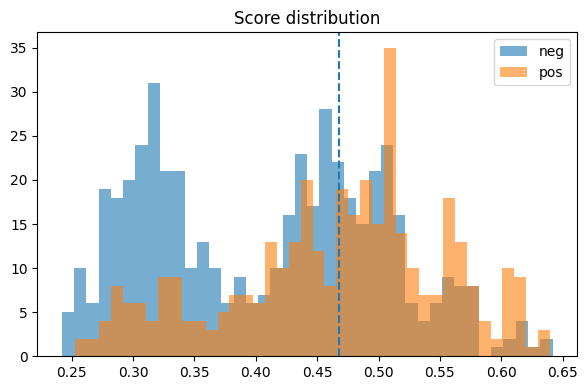

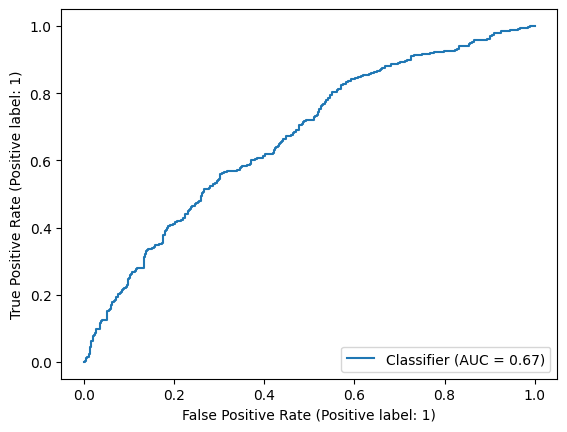

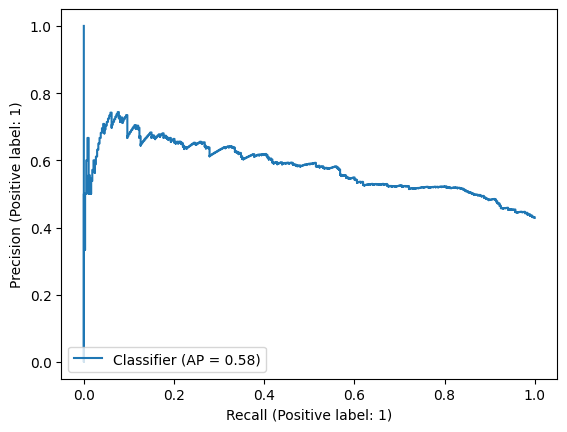

In [10]:
# Score Visualizations
import matplotlib.pyplot as plt
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay

plt.figure(figsize=(6,4))
plt.hist(probs[labels==0], bins=40, alpha=0.6, label="neg")
plt.hist(probs[labels==1], bins=40, alpha=0.6, label="pos")
plt.axvline(best_thr, ls="--")
plt.title("Score distribution"); plt.legend(); plt.tight_layout()
plt.show()

RocCurveDisplay.from_predictions(labels, probs)
plt.show()
PrecisionRecallDisplay.from_predictions(labels, probs)
plt.show()